# Assignment #3

# 1. K-means from scratch (50 points)

Code up the K-means algorithm. To test your code, sample from the three bivariate Gaussian distributions provided below and find three clusters from this sampled data. To initialize your algorihtm, you may use the initial centroids defined below. After predicting the cluster to which each data point belongs, make a scatter plot similar to the one shown below. For consistency, set the random seed to 1 before sampling from the three bivariate Gaussian distributions.

* Bivariate Gaussians
$$\mathbf{\mu_1} = \begin{bmatrix}
3.0\\
1.0\\
\end{bmatrix}$$

$$\mathbf{\mu_2} = \begin{bmatrix}
-1.0\\
3.0\\
\end{bmatrix}$$

$$\mathbf{\mu_2} = \begin{bmatrix}
-5.0\\
2.0\\
\end{bmatrix}$$

$$\mathbf{\Sigma_1} = \mathbf{\Sigma_2} = \mathbf{\Sigma_3}\begin{bmatrix}
0.9&0.3\\
0.3&0.9\\
\end{bmatrix}$$

* Initial centroids:
$$\mathbf{c_1} = \begin{bmatrix}
0.4\\
0.3\\
\end{bmatrix}$$

$$\mathbf{c_2} = \begin{bmatrix}
0.1\\
0.4\\
\end{bmatrix}$$

$$\mathbf{c_2} = \begin{bmatrix}
-2.0\\
2.0\\
\end{bmatrix}$$

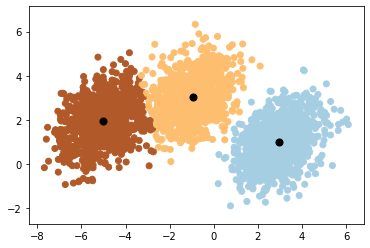

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

mu1 = np.array([3.0, 1.0])
mu2 = np.array([-1.0, 3.0])
mu3 = np.array([-5.0, 2.0])

sigma = np.array([[0.9, 0.3], [0.3, 0.9]])

np.random.seed(1)
X1 = np.random.multivariate_normal(mu1, sigma, 1000)
X2 = np.random.multivariate_normal(mu2, sigma, 1000)
X3 = np.random.multivariate_normal(mu3, sigma, 1000)
X = np.concatenate((X1,X2,X3), axis=0)

def dist(a, b):
    return np.linalg.norm(a - b)

c1 = np.array([0.4, 0.3])
c2 = np.array([0.1, 0.4])
c3 = np.array([-2.0, 2.0])
centroids = np.array([c1, c2, c3])

number_of_clusters = len(centroids)

clusters = np.zeros(len(X))
old_centroids = np.zeros(centroids.shape)
error = 1
while error != 0:
    for i in range(len(X)):
        distances = [dist(X[i], c) for c in centroids]
        cluster = np.argmin(distances)
        clusters[i] = cluster        
        
    old_centroids = deepcopy(centroids)
    
    for j in range(number_of_clusters):
        points = [X[n] for n in range(len(X)) if clusters[n] == j]
        centroids[j] = np.mean(points, axis=0)        
        
    error = dist(centroids, old_centroids)
        
plt.figure(figsize=(6, 4))
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap=plt.get_cmap('Paired'))
plt.scatter(centroids[:, 0], centroids[:, 1], c='k', s=50)
plt.axis('equal')
plt.show()

# 2. Predicting soil taxonomy (50 pts)

In the United States, soils are classified using the [USDA soil taxonomy](https://www.nrcs.usda.gov/Internet/FSE_DOCUMENTS/nrcs142p2_051232.pdf). Within the USDA soil taxonomy, the most general level is the taxonomic order. In this problem we will be using a suite of decision-tree based classification algorithms to create spatial maps of taxonomic order over western Illinois. The point observations come from the [NASIS database](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/soils/survey/tools/?cid=nrcs142p2_053552) while the environmental predictors come from Sentinel 2, the National Elevation Data, and the National Land Cover database.

All the data has already been subsetted and preprocessed and are compiled in the following NetCDF file `/data/HW/HW3.nc`. The file is split into two groups: predictors and observations. The predictors group contains a set of 1 arcsec maps for the domain and the observations group contains the in-situ taxonomic order observations with their associated geographic coordinates. Although not required, we recommend using xarray to read in these data. 

**A.** Read in and create maps of all the predictors. Describe any apparent discrepancies in spatial resolution between the maps.

**B.** Read in the in-situ observations and assemble the corresponding predictors for each site. Create the $\mathbf{X}$ array of predictors and the $\mathbf{y}$ array of observed taxonomic orders. Note that you will need to convert the taxonomic order names to integers.

**C.** Use the validation set approach to divide your data into training and test datasets. The training dataset should 20% of the data. Then fit a Decision tree using the training data and evaluate its accuracy for both the training and test datasets. Explain the differences in accuracy when evaluating the training and test datasets. To ensure reproduceability, when initializing the decision tree, set the random_state to 1.

**D.** Using  all the site data, perform a 10-fold cross validation of the decision tree and compare the results to the previous exercise. Set random_state to 1 and set shuffle to True.

**E.** Setting the number of decision trees to 100, perform a 10-fold cross validation using Bagging, Random Forests, Gradient Boosting, and Multilayer Perceptrons (ANNs). Discuss how the results of these different ensemble methods vary amongst themselves. Also compare the results to those obtained from a single decision tree. Remember to set random_state to 1.

**F.** Using 100 trees, fit a Random Forest to the entire sites dataset and report the out of bag score. Compare that result to that obtained from the cross validation. Explain what the out of bag score is and how it can be more useful than cross validation. Remember to set random_state to 1.

**G.** Starting from 10 to 100 decision trees per Random Forest, determine the optimal number of decision trees. 

**H.** After fitting a random forest with 100 trees, plot a map of the entire region of the predicted taxonomy order.

**I.** Use Principal Component Analysis (PCA) to determine a reduced number of covariates. The exact number of features that you use from PCA is not as important as much as explaining why you use the result that you use. Fit and evaluate the Random Forest fit from the corresponding principal components.

In [22]:
%%bash
# ncdump -h /data/HW/HW3/HW3.nc

## Part A

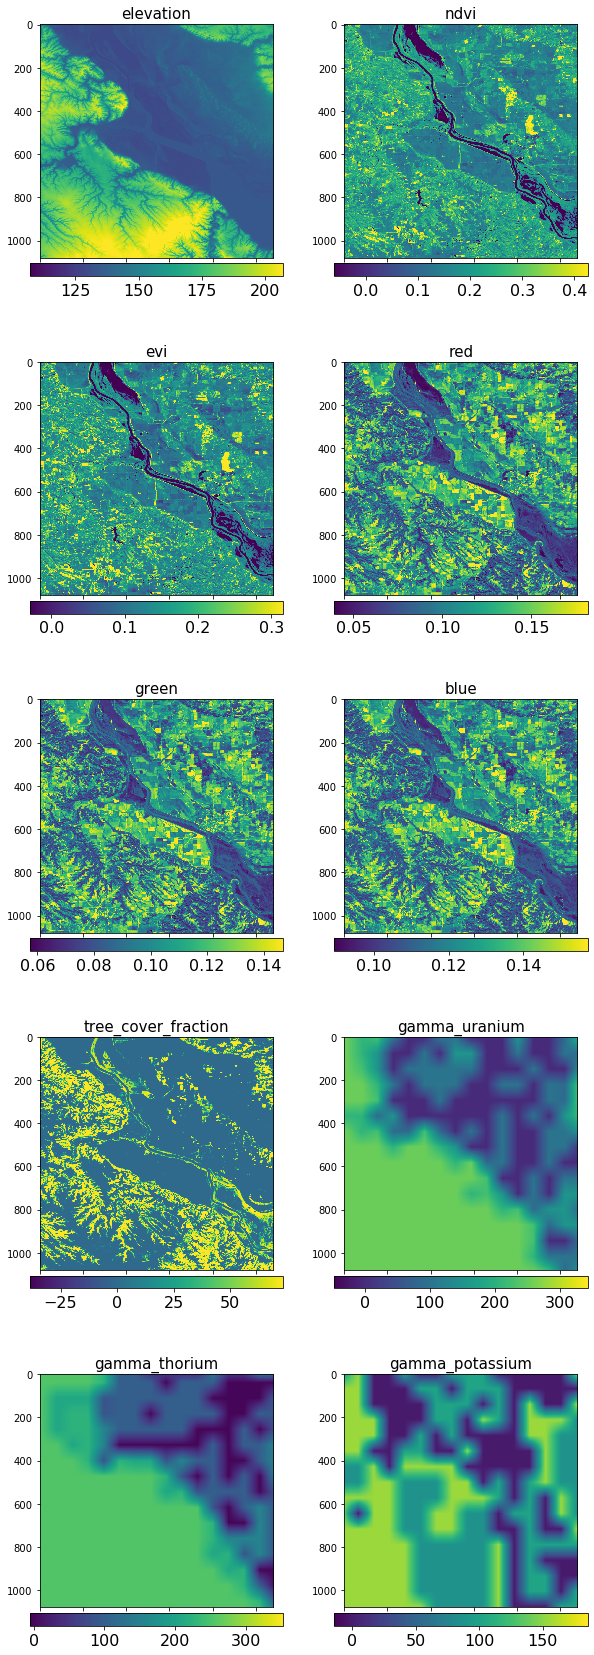

The last 3 plots: gamma_uranium, gamma_thorium and gamma_potassium have much lower resolution.


In [12]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import xarray
import os

file = '/data/HW/HW3/HW3.nc'

data = xarray.open_dataset(file, group='predictors')
predictors = ['elevation', 'ndvi', 'evi', 'red', 'green', 'blue', 'tree_cover_fraction', 'gamma_uranium', 'gamma_thorium', 'gamma_potassium']

plt.figure(figsize=(10, 30))
for i, predictor in enumerate(predictors):
    plt.subplot(5, 2, i + 1)
    # Using 2-sigma as min max could create better looking plots.
    vmin = np.mean(data[predictor]) - 2 * np.std(data[predictor])
    vmax = np.mean(data[predictor]) + 2 * np.std(data[predictor])
    plt.imshow(data[predictor], vmin=vmin, vmax=vmax, cmap='viridis')
    cb = plt.colorbar(orientation='horizontal', pad=0.02)
    cb.ax.tick_params(labelsize=16)
    plt.title(predictor, fontsize=15)

plt.show()

print("The last 3 plots: gamma_uranium, gamma_thorium and gamma_potassium have much lower resolution.")

## Part B

In [29]:
observation = xarray.open_dataset(file, group='observations')
orders_unique = np.unique(observation['taxonomic_order'])

labels = {}
for i, order_unique in enumerate(orders_unique):
    labels[order_unique] = i

y = []
for order in observation['taxonomic_order'].values:
    y.append(labels[order])
    
X = []
for predictor in predictors:
    x = data[predictor].sel(lat=observation['lat'], lon=observation['lon'], method='nearest').values
    X.append(x)

y = np.array(y)
X = np.array(X).T

## Part C

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
clf_dt = DecisionTreeClassifier(random_state=1).fit(X_train, y_train)
train_accuracy = clf_dt.score(X_train, y_train)
test_accuracy = clf_dt.score(X_test, y_test)
print(train_accuracy)
print(test_accuracy)
print("The test accuracy is much lower than training accuracy, indicating that the model is overfitted.")

0.9836065573770492
0.7096774193548387
The test accuracy is much lower than training accuracy, indicating that the model is overfitted.


## Part D

In [18]:
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

X_train, y_train = shuffle(X, y, random_state=1)
clf_dt_cv = DecisionTreeClassifier(random_state=1)
cv_scores = cross_val_score(clf_dt_cv, X_train, y_train, cv=10)
cv_score = np.mean(cv_scores)
print(cv_score)

print("The cross validation score is similar to the test accuracy in Part C, which also indicates that the model is overfitted.")

0.6930357142857143
The cross validation score is similar to the test accuracy in Part C, which also indicates that the model is overfitted.


## Part E

In [21]:
from sklearn import ensemble
from sklearn.neural_network import MLPClassifier

# Bagging
clf_df = DecisionTreeClassifier(random_state=1)
clf_bag = ensemble.BaggingClassifier(base_estimator=clf_df, n_estimators=100, random_state=1)
bag_cv_scores = cross_val_score(clf_bag, X_train, y_train, cv=10)
bag_cv_score = np.mean(bag_cv_scores)
print(bag_cv_score)

# Random Forest
clf_rf = ensemble.RandomForestClassifier(n_estimators=100, random_state=1)
rf_cv_scores = cross_val_score(clf_rf, X_train, y_train, cv=10)
rf_cv_score = np.mean(rf_cv_scores)
print(rf_cv_score)

# Gradient Boosting
clf_gb = ensemble.GradientBoostingClassifier(n_estimators=100, random_state=1)
gb_cv_scores = cross_val_score(clf_gb, X_train, y_train, cv=10)
gb_cv_score = np.mean(gb_cv_scores)
print(gb_cv_score)

# Multilayer Perceptron
clf_mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, random_state=1)
mlp_cv_scores = cross_val_score(clf_mlp, X_train, y_train, cv=10)
mlp_cv_score = np.mean(mlp_cv_scores)
print(mlp_cv_score)

print("Gradient boosting has the highest score, with random forest just slightly lower. " +
      "Multilayer perceptron has the lowest accuracy, even lower than baseline decision tree cross validation. " + 
      "Bagging method has accuracy in between and very similar to baseline decision tree cross validation.")

0.7113095238095237
0.7464880952380952
0.7514285714285714
0.6336904761904762
Gradient boosting has the highest score, with random forest just slightly lower. Multilayer perceptron has the lowest accuracy, even lower than baseline decision tree cross validation. Bagging method has accuracy in between and very similar to baseline decision tree cross validation.


## Part F

In [23]:
clf_rf_oob = ensemble.RandomForestClassifier(n_estimators=100, random_state=1, oob_score=True)
clf_rf_oob.fit(X_train, y_train)
print(clf_rf_oob.oob_score_)

print("The OOB score is computed as the number of correctly predicted rows from the out of bag sample. " + 
      "Only a subset of DTs is used for determining the OOB score. " + 
      "It's more useful because it leads to reducing the overall aggregation effect in bagging. " +
      "Also, for a small dataset, we can consume it all as the training dataset and use OOB score, which is more affordable.")

0.738562091503268
The OOB score is computed as the number of correctly predicted rows from the out of bag sample. Only a subset of DTs is used for determining the OOB score. It's more useful because it leads to reducing the overall aggregation effect in bagging. Also, for a small dataset, we can consume it all as the training dataset and use OOB score, which is more affordable.


## Part G

In [67]:
import warnings
warnings.filterwarnings('ignore')

oob_score_list = []

for i in range(10, 101):
    clf_rf = ensemble.RandomForestClassifier(n_estimators=i, random_state=1, oob_score=True)
    clf_rf.fit(X_train, y_train)
    oob_score_list.append(clf_rf.oob_score_)

optimal_number = np.argmax(oob_score_list)
print(optimal_number)

21


## Part H

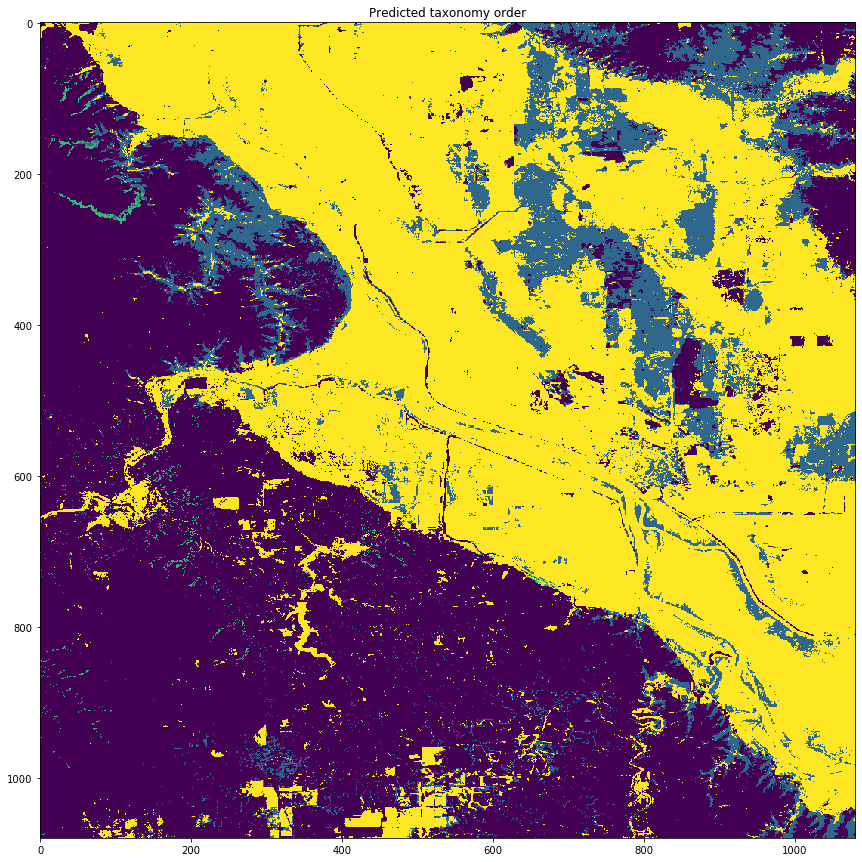

In [84]:
clf_rf = ensemble.RandomForestClassifier(n_estimators=100, random_state=1)
clf_rf.fit(X_train, y_train)

X_latlon = []
for predictor in predictors:
    X_latlon.append(data[predictor].values.flatten())    
X_latlon = np.array(X_latlon).T

y_predict = clf_rf.predict(X_latlon)
y_predict = np.reshape(y_predict, (1080,1080))

plt.figure(figsize=(15, 15))
plt.imshow(y_predict)
plt.title('Predicted taxonomy order')
plt.show()

## Part I

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pca.fit(X_train)
print(pca.explained_variance_ratio_)
print("We can find that the first 5 components are the principal ones as they have significantly higher variance ratio than others.")

pca = PCA(n_components=5)
pca.fit(X_train)
print(pca.explained_variance_ratio_)

X_principal = X_train[:, 0:5]
clf_rf_pca = ensemble.RandomForestClassifier(n_estimators=100, random_state=1, oob_score=True)
clf_rf_pca.fit(X_principal, y_train)
print(clf_rf_pca.oob_score_)
print(clf_rf_oob.oob_score_)
print("The oob score from principal components is just slightly lower than the full training, which means they can represent the whole dataset pretty well.")

[7.7150500e-01 1.2762943e-01 5.8054667e-02 2.3072178e-02 1.9738162e-02
 5.8684395e-07 5.7665012e-08 5.0625983e-09 1.2899999e-09 5.6201859e-11]
We can find that the first 5 components are the principal ones as they have significantly higher variance ratio than others.
[0.771505   0.12762943 0.05805467 0.02307218 0.01973816]
0.7254901960784313
0.738562091503268
The oob score from principal components is just slightly lower than the full training, which means they can represent the whole dataset pretty well.
